In [1]:
import numpy as np
from sklearn.decomposition import PCA
from torchvision import datasets, transforms, models
from latentmi import lmi, ksg
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import Counter


import torch.nn as nn
import torch.optim as optim

device='cuda'

torch.manual_seed(212121)

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import pandas as pd
import seaborn as sns

In [3]:
# define resnet model
class MobileNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetClassifier, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.last_channel, num_classes)  # update final layer

    def forward(self, x):
        return self.mobilenet(x)
    
def train_model(model, dataloader, epochs=5, downsample_factor=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model.train()

    best_loss = np.inf
    best_state = None 
    
    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.numpy(), labels.numpy()  # to numpy
            if downsample_factor > 1:
                inputs = downsample_resolution(inputs, downsample_factor)
            inputs, labels = torch.tensor(inputs).to(device).float(), torch.tensor(labels).to(device)  # back to tensor

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_state = model.state_dict()  # save the best so far! ⭐
            stale_epochs = 0
        else:
            stale_epochs += 1
            if stale_epochs >= 10:
                print("early stopping! no improvement :(")
                break

    if best_state is not None:
        model.load_state_dict(best_state)  # restore the champ! 🏆

    return model  # all done!


def downsample_resolution(images, factor):
    h, w = images.shape[2:]  # height and width of images
    new_h, new_w = h // factor, w // factor
    downsampled = np.zeros((images.shape[0], images.shape[1], new_h, new_w))  # output shape

    for i in range(new_h):
        for j in range(new_w):
            patch = images[:, :, i * factor:(i + 1) * factor, j * factor:(j + 1) * factor]
            avg_patch = np.mean(patch, axis=(2, 3))  # mean across height and width
            downsampled[:, :, i, j] = avg_patch

    return downsampled

# pca wrapper (top 16 pcs!)
def compute_pca(images, n_components=16):
    flat_images = images.reshape(images.shape[0], -1)
    scaler = StandardScaler()
    scaled_images = scaler.fit_transform(flat_images)  # normalize!
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(scaled_images)
    return pcs

def resample_one_v_all(true_labels, target_label):
    target_indices = []
    other_indices = []
    for i, label in enumerate(true_labels):
        if target_label == label:
            target_indices.append(i)
        else:
            other_indices.append(i)

    other_indices = np.random.choice(other_indices, len(target_indices), replace=False)
    indices = np.concatenate([target_indices, other_indices])
    return indices.astype(int)


def estimate_mi_repr(model, dataloader, downsample_factor=1):
    model.eval()
    true_labels = []
    last_layer_reprs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.numpy()  # to numpy
            if downsample_factor > 1:
                inputs = downsample_resolution(inputs, downsample_factor)  # downsample
            inputs = torch.tensor(inputs).to(device).float()  # back to tensor
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            true_labels.append(labels.numpy())
            last_layer_reprs.append(outputs.cpu().numpy())

    true_labels = np.concatenate(true_labels)
    last_layer_reprs = np.concatenate(last_layer_reprs)

    MIs = []
    N_samples = []
    labels = []

    for label in np.unique(true_labels):
        N_samples.append(np.sum(true_labels == label))
        labels.append(label)
        idx = resample_one_v_all(true_labels, label)
        bin_y = true_labels[idx] == label
        reprs = last_layer_reprs[idx]
        
        MIs.append(np.nanmean(lmi.estimate(bin_y.reshape(-1, 1), reprs)[0]))

    # all labels → one-hot!
    uniques = np.unique(true_labels).tolist()
    n_classes = len(uniques)
    one_hot_labels = np.eye(n_classes)[[uniques.index(s) for s in true_labels]]
    MIs.append(np.nanmean(lmi.estimate(one_hot_labels, last_layer_reprs, N_dims=16)[0]))
    N_samples.append(len(true_labels))
    labels.append('all')

    print(MIs)

    return MIs, N_samples, labels


In [4]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),  # ensure RGB
    transforms.Resize((240, 240)),  # resize to a manageable resolution
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalize
])

# load dataset
Caltech101 = datasets.Caltech101(root='../data', download=True, transform=transform)

# get class labels
labels = Caltech101.y  # class indices for the dataset

# count occurrences of each class
class_counts = Counter(labels)

# find top n largest classes
top_n = 5
top_n_classes = [cls for cls, _ in class_counts.most_common(top_n)]

# subset the dataset to include only samples from these top classes
indices = [i for i, label in enumerate(labels) if label in top_n_classes]
subset = torch.utils.data.Subset(Caltech101, indices)

# split the subset into train and validation sets
N = len(subset)
print(f"{N} total samples")
train_set, val_set = torch.utils.data.random_split(subset, [N//2, N - N//2])

# create data loaders
data_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)

Files already downloaded and verified
2707 total samples


In [5]:
d = {
    "Factor" : [],
    "MI" : [],
    "Class label" : [],
    "N instances of label" : []
}

MIs = []
factors = [1, 2, 4, 5, 8, 10, 20, 25, 40, 50, 100, 200]
print("factors to process:", factors)

# process each factor
for factor in factors:
    print(f"downsampling by factor {factor}...")

    model = MobileNetClassifier(num_classes=101)
    model.to('cuda')
    train_model(model, data_loader, epochs=10, downsample_factor=factor)

    # estimate mutual info
    mi, n_inst, labels = estimate_mi_repr(model, val_loader, downsample_factor=factor)
    d['MI'] += mi
    d['Factor'] += [factor] * len(mi)
    d['Class label'] += labels
    d["N instances of label"] += n_inst

/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


factors to process: [1, 2, 4, 5, 8, 10, 20, 25, 40, 50, 100, 200]
downsampling by factor 1...


Epoch 1/10, Loss: 3.0210
Epoch 2/10, Loss: 0.5096
Epoch 3/10, Loss: 0.0687
Epoch 4/10, Loss: 0.0303
Epoch 5/10, Loss: 0.0150
Epoch 6/10, Loss: 0.0175
Epoch 7/10, Loss: 0.0107
Epoch 8/10, Loss: 0.0086
Epoch 9/10, Loss: 0.0065
Epoch 10/10, Loss: 0.0069
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.9438329062409183, 0.97711219254754, 0.9992929705429503, 1.001599977167972, 0.9866381119895986, 2.178158520784438]
downsampling by factor 2...


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 2.6947
Epoch 2/10, Loss: 0.3289
Epoch 3/10, Loss: 0.0504
Epoch 4/10, Loss: 0.0276
Epoch 5/10, Loss: 0.0189
Epoch 6/10, Loss: 0.0120
Epoch 7/10, Loss: 0.0064
Epoch 8/10, Loss: 0.0080
Epoch 9/10, Loss: 0.0079
Epoch 10/10, Loss: 0.0059
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.9931941763543406, 0.9624423364159715, 1.0005081816653076, 0.9919240445018626, 0.9975464091253381, 2.1545502882529655]
downsampling by factor 4...


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 3.2224
Epoch 2/10, Loss: 0.7448
Epoch 3/10, Loss: 0.1525
Epoch 4/10, Loss: 0.0464
Epoch 5/10, Loss: 0.0238
Epoch 6/10, Loss: 0.0112
Epoch 7/10, Loss: 0.0090
Epoch 8/10, Loss: 0.0109
Epoch 9/10, Loss: 0.0067
Epoch 10/10, Loss: 0.0062
epoch 237 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.9981335561625256, 0.9482686743601078, 0.9858913575846001, 0.9827495414457879, 0.9803632018318966, 2.1430433301950256]
downsampling by factor 5...


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 3.4396
Epoch 2/10, Loss: 1.0244
Epoch 3/10, Loss: 0.2307
Epoch 4/10, Loss: 0.0617
Epoch 5/10, Loss: 0.0450
Epoch 6/10, Loss: 0.0199
Epoch 7/10, Loss: 0.0160
Epoch 8/10, Loss: 0.0132
Epoch 9/10, Loss: 0.0125
Epoch 10/10, Loss: 0.0078
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.9178833588975535, 0.8783083035114794, 0.9751651926008511, 0.9831656171228336, 0.9264539564565063, 2.046258664709089]
downsampling by factor 8...


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 3.5008
Epoch 2/10, Loss: 1.3954
Epoch 3/10, Loss: 0.4936
Epoch 4/10, Loss: 0.2007
Epoch 5/10, Loss: 0.1022
Epoch 6/10, Loss: 0.0585
Epoch 7/10, Loss: 0.0620
Epoch 8/10, Loss: 0.0568
Epoch 9/10, Loss: 0.0306
Epoch 10/10, Loss: 0.0269
epoch 165 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.8603772647848393, 0.8093393032612061, 0.9211954846221392, 0.8724822758855596, 0.7623783711093451, 1.9350708970644228]
downsampling by factor 10...


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 3.5978
Epoch 2/10, Loss: 1.4058
Epoch 3/10, Loss: 0.4934
Epoch 4/10, Loss: 0.2302
Epoch 5/10, Loss: 0.1182
Epoch 6/10, Loss: 0.0671
Epoch 7/10, Loss: 0.0508
Epoch 8/10, Loss: 0.0352
Epoch 9/10, Loss: 0.0271
Epoch 10/10, Loss: 0.0215
epoch 182 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻[0.9025171565138154, 0.8223906737450323, 0.8799197777032749, 0.8655389442509426, 0.791256890738618, 1.9587746935032662]
downsampling by factor 20...


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 3.8744
Epoch 2/10, Loss: 2.0569
Epoch 3/10, Loss: 1.0037
Epoch 4/10, Loss: 0.5754
Epoch 5/10, Loss: 0.3775
Epoch 6/10, Loss: 0.2522
Epoch 7/10, Loss: 0.1969
Epoch 8/10, Loss: 0.1285
Epoch 9/10, Loss: 0.1206
Epoch 10/10, Loss: 0.0820
epoch 150 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.6812920560422128, 0.7154562377438529, 0.6986759574676795, 0.6425505251125828, 0.534986214634611, 1.6766987612487403]
downsampling by factor 25...


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 3.9094
Epoch 2/10, Loss: 2.0662
Epoch 3/10, Loss: 1.0713
Epoch 4/10, Loss: 0.5905
Epoch 5/10, Loss: 0.4204
Epoch 6/10, Loss: 0.3086
Epoch 7/10, Loss: 0.2239
Epoch 8/10, Loss: 0.1514
Epoch 9/10, Loss: 0.1263
Epoch 10/10, Loss: 0.0981
epoch 125 (of max 300) 🌻🌻🌻🌻🌻🌻🌻[0.7041366613822048, 0.7597030010274346, 0.6890736551919218, 0.7147200052891848, 0.39672585976387703, 1.5803182580503825]
downsampling by factor 40...


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 3.7652
Epoch 2/10, Loss: 2.0313
Epoch 3/10, Loss: 1.1418
Epoch 4/10, Loss: 0.7432
Epoch 5/10, Loss: 0.5633
Epoch 6/10, Loss: 0.4620
Epoch 7/10, Loss: 0.3448
Epoch 8/10, Loss: 0.2896
Epoch 9/10, Loss: 0.2692
Epoch 10/10, Loss: 0.2092
epoch 142 (of max 300) 🌻🌻🌻🌻🌻🌻[0.5258278733722792, 0.5806349159583933, 0.6564375499662111, 0.6363505182561945, 0.4356484792969006, 1.3775106106037125]
downsampling by factor 50...


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 4.0522
Epoch 2/10, Loss: 2.3243
Epoch 3/10, Loss: 1.3953
Epoch 4/10, Loss: 1.0190
Epoch 5/10, Loss: 0.7642
Epoch 6/10, Loss: 0.6271
Epoch 7/10, Loss: 0.5940
Epoch 8/10, Loss: 0.5195
Epoch 9/10, Loss: 0.4685
Epoch 10/10, Loss: 0.4275
epoch 148 (of max 300) 🌻🌻🌻🌻🌻[0.5665508122935629, 0.6999661300363023, 0.44039789961615244, 0.5354135733986652, 0.14798597907672184, 1.149467033501329]
downsampling by factor 100...


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 3.9703
Epoch 2/10, Loss: 2.4629
Epoch 3/10, Loss: 1.6564
Epoch 4/10, Loss: 1.3024
Epoch 5/10, Loss: 1.0946
Epoch 6/10, Loss: 0.9851
Epoch 7/10, Loss: 0.9306
Epoch 8/10, Loss: 0.8587
Epoch 9/10, Loss: 0.8260
Epoch 10/10, Loss: 0.7753
epoch 146 (of max 300) 🌻🌻🌻🌻🌻[0.2065421812874345, 0.4871993024517873, 0.454825043072068, 0.2921020109254474, 0.0964146332183498, 0.864577199209775]
downsampling by factor 200...


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 4.1079
Epoch 2/10, Loss: 2.5680
Epoch 3/10, Loss: 1.8039
Epoch 4/10, Loss: 1.4595
Epoch 5/10, Loss: 1.3190
Epoch 6/10, Loss: 1.1724
Epoch 7/10, Loss: 1.1352
Epoch 8/10, Loss: 1.1373
Epoch 9/10, Loss: 1.0916
Epoch 10/10, Loss: 1.0670
epoch 125 (of max 300) 🌻🌻🌻🌻[0.15712722144063038, 0.42397472482840437, 0.21306523999566376, 0.24651373081639438, 0.05059722184513552, 0.6383509652033368]


In [6]:
df = pd.DataFrame(data=d)
df.to_csv('../results/Caltech101_lastlayer_resolution.csv')

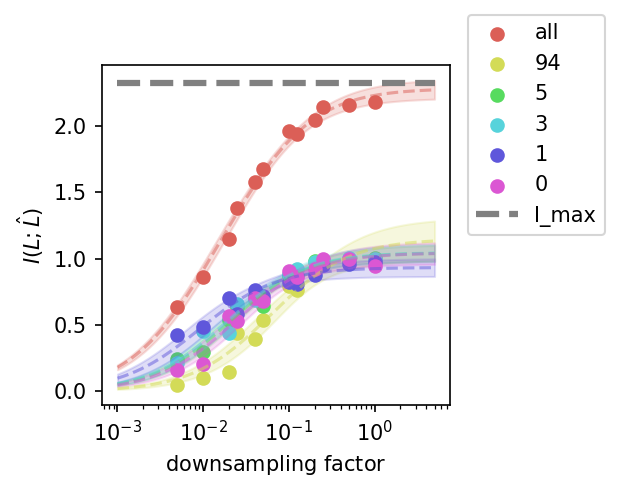

In [7]:
from lmfit import Model

def info_scaling(x, A, B):
    return 0.5 * np.log2(((x)*B+ 1)/(1+A*(x)))

fig = plt.figure(figsize=(3,3), dpi=150)


classes = df[df['N instances of label'] > 100]['Class label'].unique()
palette = sns.color_palette("hls", len(classes))

for i, x in enumerate(classes[::-1]):
    # prepare data
    x_data = 1/df[df['Class label'] == x]['Factor']
    y_data = df[df['Class label'] == x]['MI']

    # create model and parameters
    model = Model(info_scaling)
    params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
    params['A'].min = 0  # set bounds
    params['B'].min = 0

    # fit model
    result = model.fit(y_data, params, x=x_data)

    # generate fit line
    x_fit = np.linspace(x_data.min()/5, 5*x_data.max(), 10**5)
    y_fit = model.eval(params=result.params, x=x_fit)

    # calculate confidence bands
    y_upper = result.eval_uncertainty(params=result.params, 
                                      x=x_fit, sigma=2)
    y_lower = -y_upper

    # plot fit and data
    plt.plot(x_fit, y_fit, linestyle='--', color=palette[i], alpha=0.5)
    plt.fill_between(x_fit, y_fit + y_upper, y_fit + y_lower, color=palette[i], alpha=0.2)
    plt.scatter(x_data, y_data, color=palette[i], label=x)

I_max = np.log2(top_n)
plt.plot([np.min(x_fit), np.max(x_fit)], [I_max, I_max], linestyle='--', 
         color='grey', label='I_max', lw=3)


plt.xlabel(r'$\text{downsampling factor}$')
plt.ylabel(r'$I(L; \hat{L})$')
plt.xscale('log')
plt.legend(loc=(1.05, 0.5))